In [952]:
import os
import pickle
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor  # pip install xgboost
from xgbexcel import XGBtoExcel
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [953]:
!pip install xgbexcel


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# Считывание данных

In [954]:
convert = lambda x: x if 0 < x > 150 else 0
convert = np.vectorize(convert)

Функция для нормализации предсказаний

Предсказаний меньше нуля никак не может быть, так что мы можем ограничить все предсказания

In [955]:
warnings.filterwarnings("ignore")

Отключение предупреждений от моделей

In [956]:
if not os.path.isdir("raw_data"):
    os.chdir("../")

Установка рабочей директории (тк данные располагаются на папку выше)

In [957]:
data = pd.read_excel("raw_data/Статистика_для_графиков_3_д_ТЭЦ2_УРУТ_130.xlsx")

In [958]:
data.columns

Index([                                                  'Дата',
                           'Выработка электроэнергии ТА гр.130',
                                 'Отпуск тепла из ТО ТА гр.130',
       'Удельный расход условного топлива на отпуск э/э гр.130',
                                                   'Unnamed: 4',
                                       'Предсказание полином 2',
                                           0.033374592702317095],
      dtype='object')

Считывание данных

# Предобработка данных

In [959]:
target = "Удельный расход условного топлива на отпуск э/э гр.130"

In [960]:
columns_for_predictions = [
    column
    for column in data.columns[:-1]
    if "130" in column and column != "Удельный расход тепла на выработку э/э ТА гр.130"
]

Получаем все колонки, связанные с "Удельный расход условного топлива на отпуск э/э гр.130"

In [961]:
columns_for_predictions

['Выработка электроэнергии ТА гр.130',
 'Отпуск тепла из ТО ТА гр.130',
 'Удельный расход условного топлива на отпуск э/э гр.130']

## Добавление фич даты

In [962]:
date = np.array([[0, 0, 0]], dtype=int)
for i in data["Дата"]:
    date = np.vstack([date, str(i.date()).split("-")])

Разделяем значение даты на день/месяц/год

In [963]:
date = date[1:]

In [964]:
data["year"] = date[:, 0]
data.year = data.year.apply(int)

In [965]:
data["month"] = date[:, 1]
data.month = data.month.apply(int)

In [966]:
data["day"] = date[:, 2]
data.day = data.day.apply(int)

In [967]:
data = data.drop(["Дата"], axis=1)

In [968]:
data.isna().sum()

Выработка электроэнергии ТА гр.130                           0
Отпуск тепла из ТО ТА гр.130                                 0
Удельный расход условного топлива на отпуск э/э гр.130       0
Unnamed: 4                                                1090
Предсказание полином 2                                       0
0.033374592702317095                                         0
year                                                         0
month                                                        0
day                                                          0
dtype: int64

In [969]:
data = data[columns_for_predictions + ["day", "month", "year"]]

# Обработка выбросов

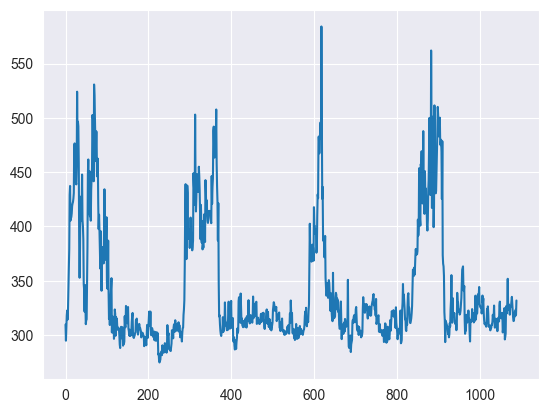

In [970]:
plt.plot(data[target]);

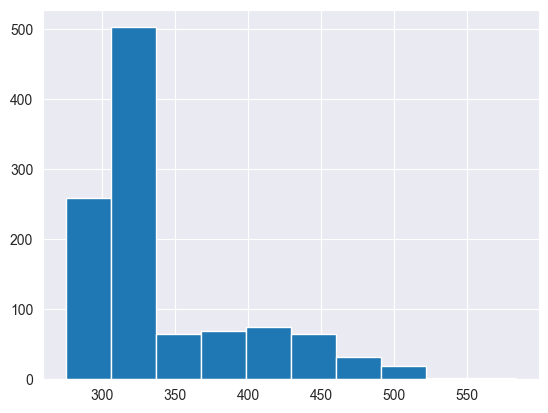

In [971]:
plt.hist(data[target]);

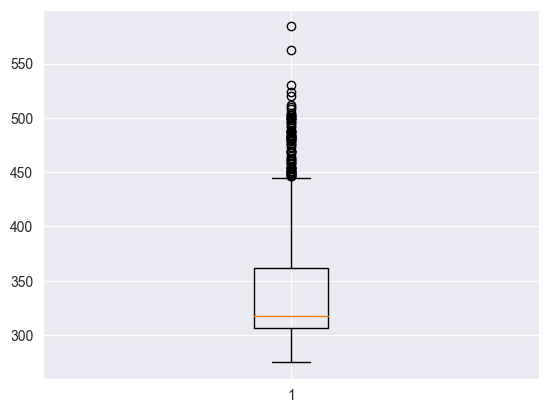

In [972]:
plt.boxplot(data[target]);

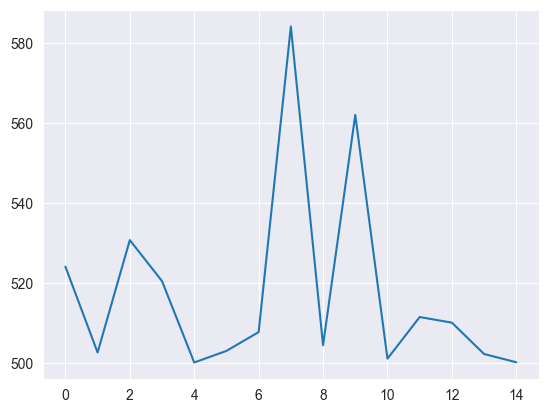

In [973]:
plt.plot(np.array(data.loc[data[target] > 500][target]));

In [974]:
data = data.loc[data[target] < 507]
data = data.loc[data[target] > 100]

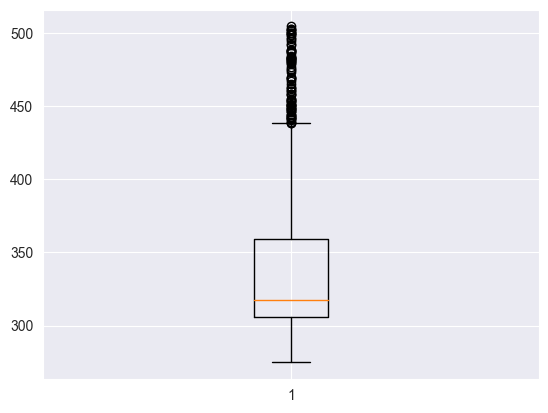

In [975]:
plt.boxplot(data[target]);

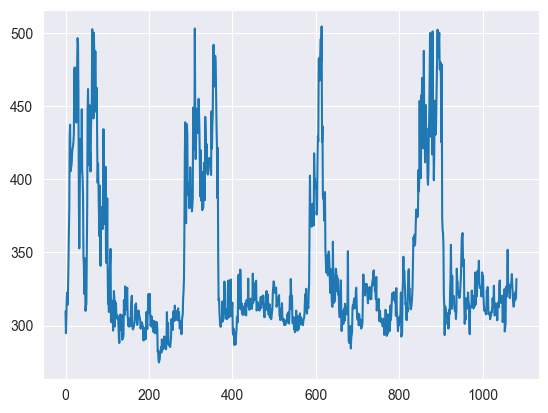

In [976]:
plt.plot(np.array(data[target]));

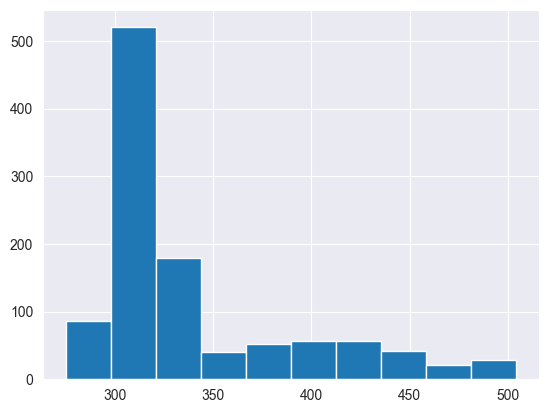

In [977]:
plt.hist(data[target]);

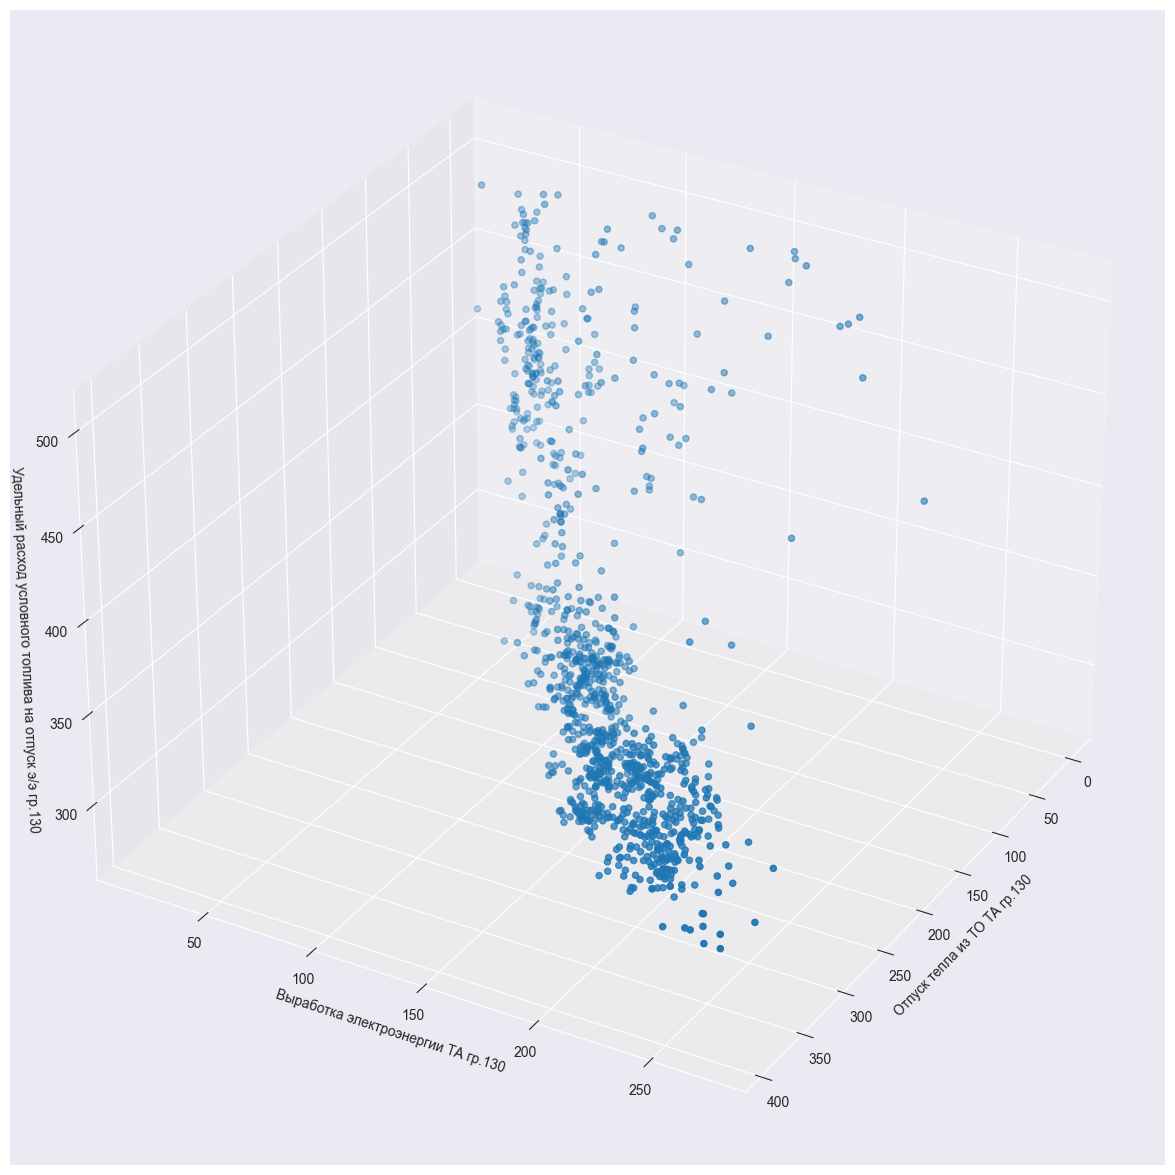

In [978]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
fig.set_figheight(15)
fig.set_figwidth(15)
ax.scatter(
    data[columns_for_predictions[1]],
    data[columns_for_predictions[0]],
    data[columns_for_predictions[2]]
)

ax.view_init(30, 30)
ax.set_xlabel(columns_for_predictions[1])
ax.set_ylabel(columns_for_predictions[0])
ax.set_zlabel(columns_for_predictions[2]);

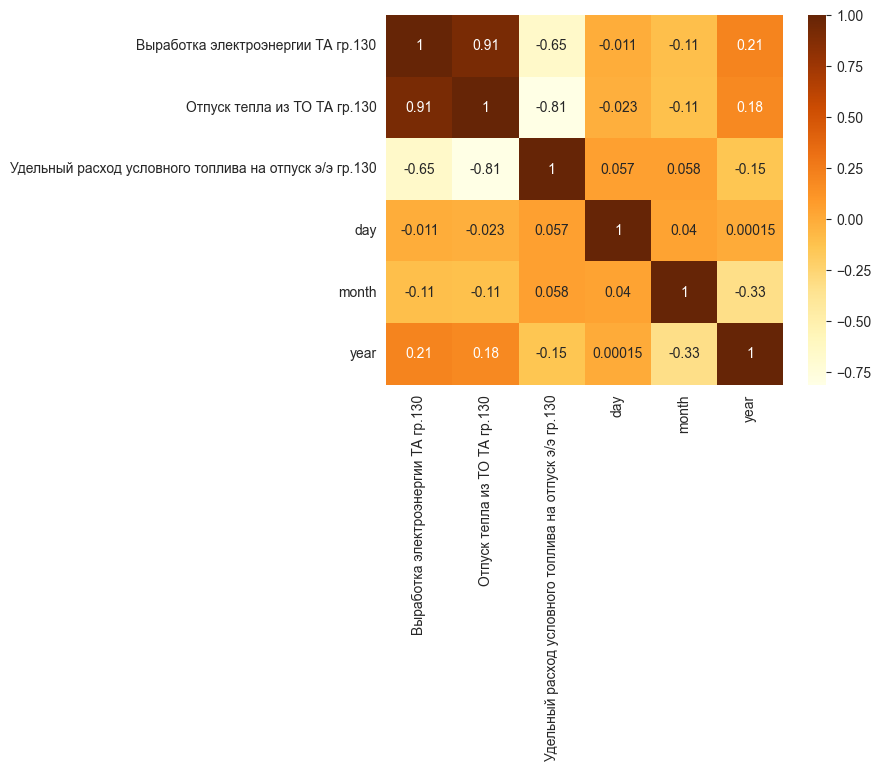

In [979]:
sns.heatmap(
    data.corr(), annot=True,
    cmap=sns.color_palette("YlOrBr", as_cmap=True)
);

# Создание датасета для обучения
## Разделение данных

In [980]:
X = data.drop(target, axis=1)

In [981]:
y = data[target]

In [982]:
out_shape = 1

# Разделение на тренировочную и тестовую выборки

In [983]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=30)

# XGB

In [984]:
model = XGBRegressor()

In [985]:
X = np.array(X)
y = np.array(y)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [986]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

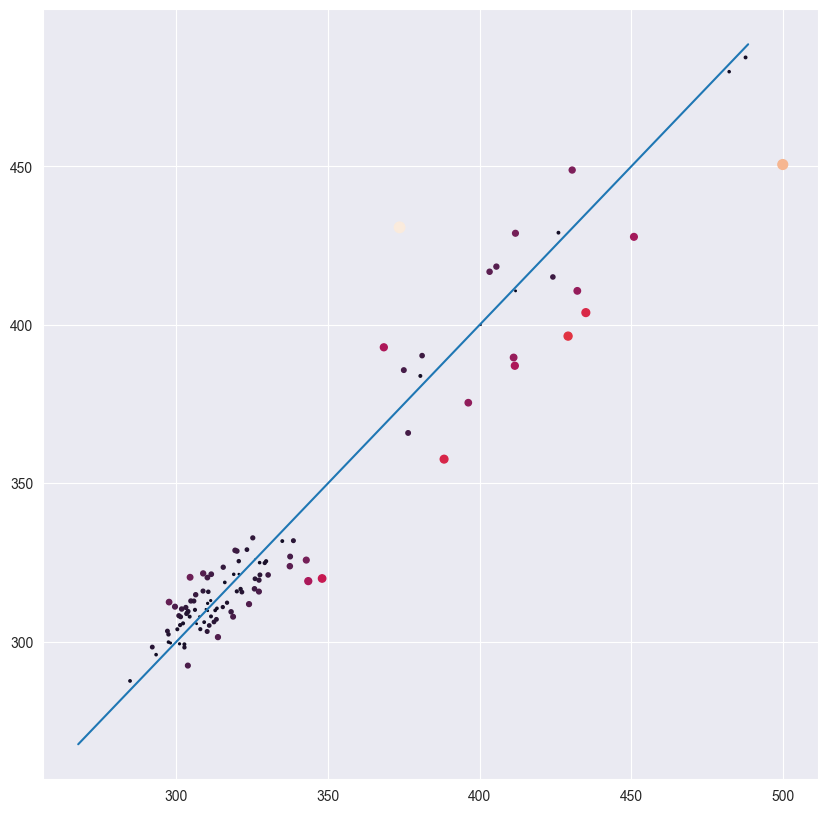

In [987]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);

In [988]:
predictions = np.array(model.predict(X_test))

In [989]:
# data["predictions"] = predictions
# data.to_excel("Статистика для графиков 3 д ТЭЦ2 (УРУТ-130).xlsx")

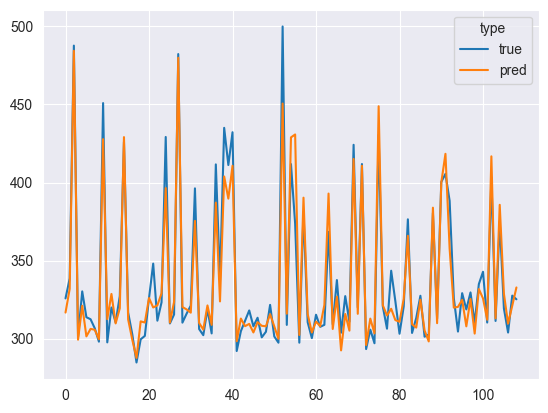

In [990]:
plt.plot(y_test, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("xgb_predictions.png");

In [991]:
r2_score(y_test, predictions)

0.9234651571100364

In [992]:
for real, pred in zip(y_test, predictions):
    if abs(real - pred) > 20:
        print(
            "real: {0}, pred: {1}, diff: {2}".format(
                real, pred, abs(real - pred)
            )
        )

real: 450.898516, pred: 427.7822265625, diff: 23.116289437499972
real: 348.03684, pred: 319.92706298828125, diff: 28.109777011718734
real: 429.177924, pred: 396.4405822753906, diff: 32.737341724609394
real: 396.255965, pred: 375.41571044921875, diff: 20.840254550781253
real: 411.607633, pred: 387.0857849121094, diff: 24.521848087890646
real: 435.033737, pred: 403.8620300292969, diff: 31.1717069707031
real: 411.209838, pred: 389.6901550292969, diff: 21.519682970703116
real: 432.218168, pred: 410.7284240722656, diff: 21.489743927734366
real: 499.985903, pred: 450.61529541015625, diff: 49.37060758984376
real: 373.586281, pred: 430.7796325683594, diff: 57.19335156835939
real: 368.395934, pred: 392.911865234375, diff: 24.51593123437499
real: 343.471583, pred: 319.0916442871094, diff: 24.379938712890635
real: 388.270435, pred: 357.60009765625, diff: 30.67033734375002


In [993]:
abs(y_test - predictions).max()

57.19335156835939

In [994]:
model = XGBRegressor()

In [995]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [996]:
predictions = np.array(model.predict(X))

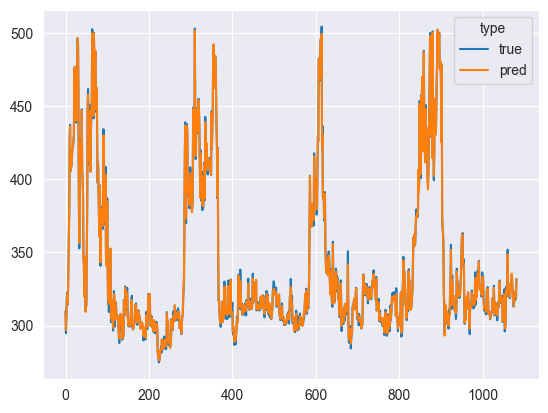

In [997]:
plt.plot(y, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("predictions.png");

In [998]:
r2_score(y, predictions)

0.9988951239865285

In [999]:
for real, pred in zip(y, predictions):
    if abs(real - pred) > 20:
        print(
            "real: {0}, pred: {1}, diff: {2}".format(
                real, pred, abs(real - pred)
            )
        )

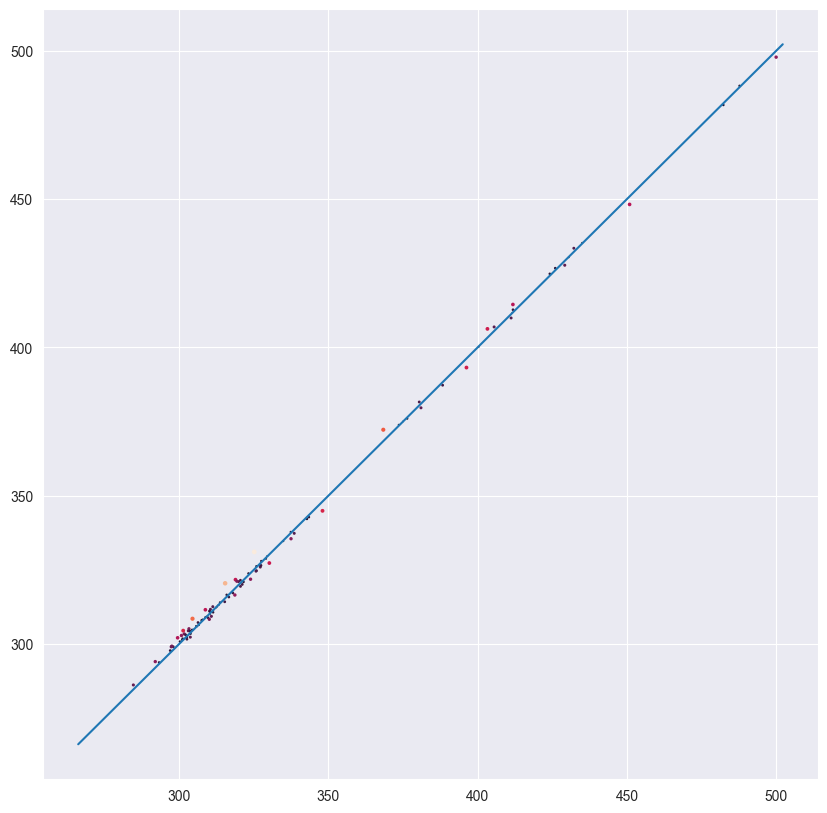

In [1000]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);

In [1001]:
if not os.path.isdir("models"):
    os.mkdir("models")

In [1002]:
with open("models/xgb_fuelTA130_099889.bf", "+wb") as file:
    pickle.dump(model, file)

In [1003]:
columns_for_predictions

['Выработка электроэнергии ТА гр.130',
 'Отпуск тепла из ТО ТА гр.130',
 'Удельный расход условного топлива на отпуск э/э гр.130']

In [1004]:
excel = XGBtoExcel(model)
excel.save_expr("models/xgb0.99.txt")

Saved!


In [1005]:
len(XGBtoExcel(model).expression)

107889